In [67]:
from gw_eccentricity import load_waveform, load_data, get_available_methods, measure_eccentricity
from gw_eccentricity.load_data import get_available_waveform_origins, get_load_waveform_defaults, get_load_waveform_docs
import matplotlib.pyplot as plt
from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict
import numpy as np
from tqdm import tqdm
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc import waveform
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from pycbc.waveform import get_td_waveform, get_fd_waveform
import math
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
%run GW_functions.ipynb

In [69]:
def sph_harmonics(inc,ell):
    L=ell
    #inc = 10
    theta = inc
    for l in range(L,L+1):

        for m in range(-l,l+1):
            dlm = 0;
            k1 = max([0, m-2]);
            k2 = min([l+m, l-2]);

            #if(m==l or m==l-1):
            for k in range(k1,k2+1):
                A = []; B = []; cosTerm = []; sinTerm = []; dlmTmp = [];

                A = (-1)**k*math.sqrt(math.factorial(l+m)*math.factorial(l-m)*math.factorial(l+2)*math.factorial(l-2));
                B = math.factorial(k)*math.factorial(k-m+2)*math.factorial(l+m-k)*math.factorial(l-k-2);

                cosTerm = pow(math.cos(theta/2), 2*l+m-2*k-2);
                sinTerm = pow(math.sin(theta/2), 2*k-m+2);

                dlmTmp = (A/B)*cosTerm*sinTerm;
                dlm = dlm+dlmTmp

            Ylm = math.sqrt((2*l+1)/(4*math.pi))*dlm
            #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
            if m==ell:
                #globals()['sph' + str(l) + str(m)] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphlm = Ylm
            elif m==-ell:
                #globals()['sph' + str(l) + '_' + str(abs(m))] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphl_m = Ylm
            else:
                continue
    return sphlm, sphl_m

In [70]:
def PNparams(M,q,d,f_low,e0,delta_t):
    M2=M/(1+q)
    M1=M2*q
    hpVec_PN, hcVec_PN = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, 
                             delta_t=delta_t, 
                             f_lower=f_low, 
                             eccentricity=e0,
                             distance=d)
    
    modetopolfac=4*(5/(64*np.pi))**(1/2)  #conversion factor between mode amplitude and strain amplitude
                                          # check 0704.3764 equation 7 for details
    M_SI = M * MSUN_SI
    D_SI = 10**6 * PC_SI * d
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
    tVec_PN=hpVec_PN.sample_times/(M*MTSUN_SI)
    fVec_PN=waveform.utils.frequency_from_polarizations(hpVec_PN, hcVec_PN)
    return phase_EccTD, tVec_PN

# $22$

In [71]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=20
inc=0
d0=1
delta_t=1./4096

eta=neu=nu=q/(1+q)**2
G=c=M=d=1
M2=M/(1+q)
M1=M2*q
Delta=math.sqrt(1-(4*neu))
eta=nu=neu
gamma=EulerGamma=0.577215664901
mode2polfac=(5/(64*np.pi))**(1/2)
    
conv=M*MTSUN_SI
M_SI=M0 * MSUN_SI
D_SI=(10**(6)) * PC_SI * d
    
xlow = ((M0*MTSUN_SI*math.pi*flow)**(2/3))
f_low = (xlow**(3/2)/(M*MTSUN_SI*math.pi))
    
%run GW_functions.ipynb
    
x=xlow
v=math.sqrt(x)
    
xie=v**3
    
if delta_t>=1/2**14:
    del_t = 1/2**14
elif delta_t<1/2**14 and delta_t>=1/2**16:
    del_t = 1/2**16
elif delta_t<1/2**16 and delta_t>=1/2**18:
    del_t = 1/2**18
else:
    del_t = 1/2**20
        
phase_EccTD, tVec_PN = PNparams(M,q,d,f_low,e0,del_t)
    
tC_NR = 0
    
x0=xlow
xi0=x0**(3/2)
v0=xi0**(1/3)
   
theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta, theta0, e0, M, eta)

#print(fVec)
plotIdx2=np.nonzero(fVec>=0)
fVec=fVec[plotIdx2]
xiVec=(np.pi*M*fVec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xband=np.where(xVec<=1/6)
xVec = xVec[xband]
maxPNidx = len(xVec)
tVec_PN=tVec_PN[:maxPNidx]
    
    
lp=2
mp=2
    
j=0
h22=[]
h2_2=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=mean_anomaly(xie, xi0, l0, eta, e0)
    #print(l)
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h22.append(abs(hlm))   #abs not chnge
    h2_2.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph22, sph2_2 = sph_harmonics(inc,lp)
    
h = np.multiply(h22,1) #+np.multiply(h2_2,sph2_2)  chnge
hp=(np.real(h)) 
hc=(np.imag(h)) 
time = tVec_PN - tVec_PN[-1]

mode2polfac=(5/(64*np.pi))**(1/2)  
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = tVec_PN * conv_t
    
hp_intrp = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp2 = np.arange(time[0], time[-1], delta_t)
hp_intrp2 = hp_intrp(t_intrp2)
hc_intrp2 = hc_intrp(t_intrp2)

100%|██████████████████████████████████████| 1691/1691 [00:01<00:00, 944.87it/s]


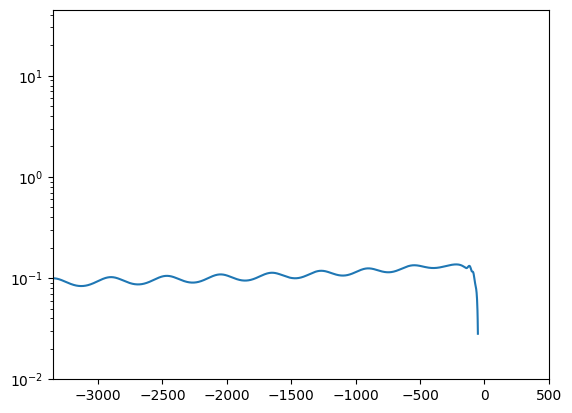

In [72]:
plt.yscale('log')
plt.xlim(xmin=-3350)
plt.xlim(xmax=500)
plt.ylim(ymax=4.5e1)
plt.ylim(ymin=1e-2)
plt.plot(t_intrp2/(M0*MTSUN_SI),abs(hp_intrp2+1j*hc_intrp2)/(G_SI*M_SI/D_SI/C_SI/C_SI))  #mode2polfac removed

[0.02562868 0.02562869 0.02562871 ... 0.06068228 0.06068523 0.06068671]


100%|██████████████████████████████████| 181356/181356 [03:52<00:00, 780.67it/s]


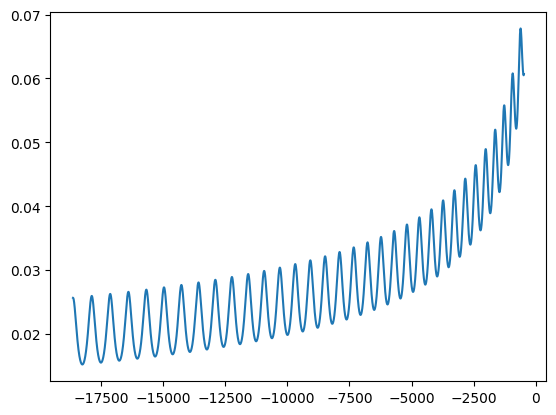

In [73]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=20
inc=10*np.pi/180
d0=1
delta_t=1./1024
x0=xlow=0.045
eta=neu=nu=q/(1+q)**2
Delta=math.sqrt(1-(4*neu))


kwargs = {
    "approximant": "EccentricTD",
    "q": q,
    "ecc": e0,
    "chi1": [0.0,0.0,0.0],
    "chi2": [0.0,0.0,0.0],
    "mean_ano": l0,
    "Momega0": 0.045**(3/2),
    "physicalUnits":True,
    "M": M0,
    "D":d0,
    "include_zero_ecc":True,
    }


method = "ResidualAmplitude"
origin = "LAL"
dataDict2 = load_waveform(origin, **kwargs)
hp22 = np.real(dataDict2["hlm"][(2,2)])
hc22 = np.imag(dataDict2["hlm"][(2,2)])

phs = np.unwrap(np.angle(hp22-1j*hc22)*2)/2
#plt.plot(dataDict2["t"]/(M0*MTSUN_SI),phs)
phs_intrp = interp1d(dataDict2["t"]/(M0*MTSUN_SI), phs ,kind='cubic',fill_value='extrapolate')

return_dict = measure_eccentricity(fref_in=30,method=method,dataDict=dataDict2)

gwecc_object = return_dict["gwecc_object"]
Time_data = gwecc_object.get_omega22_average()[0]  #extract the time values
Omega_avg = gwecc_object.get_omega22_average()[1]

del_t=np.abs(np.mean((np.diff(Time_data))))
phs=phs_intrp(Time_data/(M0*MTSUN_SI))
omega2 = (M0*MTSUN_SI/del_t)*np.gradient(phs)
print(omega2)
plt.plot(Time_data/(M0*MTSUN_SI),omega2)
return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
Fvec = Omega_avg/(2*PI) #Average frequency array

Fvec=Fvec*(M0*MTSUN_SI)


Eccentricity_new = return_dict1["eccentricity"]
Mean_anomaly = return_dict1["mean_anomaly"]


xiVec=(np.pi*M*Fvec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xVec = xVec

lp=2
mp=2
    
j=0
h22=[]
h2_2=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=Mean_anomaly[j]
    e=Eccentricity_new[j]
    psi= phs[j] #phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h22.append(abs(hlm)) #chnge
    h2_2.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph22, sph2_2 = sph_harmonics(inc,lp)
    
h = np.multiply(h22,1) #+np.multiply(h2_2,sph2_2) chgne
hp=(np.real(h)) 
hc=(np.imag(h)) 

mode2polfac=(5/(64*np.pi))**(1/2)  
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = Time_data
hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp_new2 = np.arange(time[0], time[-1], delta_t)
hp_intrp_new2 = hp_intrp_new(t_intrp_new2)
hc_intrp_new2 = hc_intrp_new(t_intrp_new2)



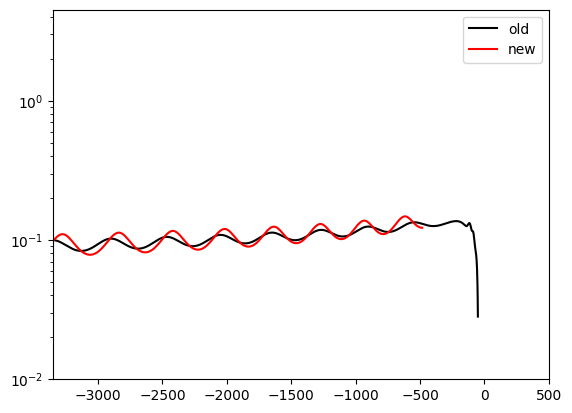

In [74]:
plt.yscale('log')
plt.xlim(xmin=-3350)
plt.xlim(xmax=500)
plt.ylim(ymax=4.5e0)
plt.ylim(ymin=1e-2)
plt.plot(t_intrp2/(M0*MTSUN_SI),abs(hp_intrp2+1j*hc_intrp2)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'k-',label='old')
plt.plot(t_intrp_new2/(M0*MTSUN_SI),abs(hp_intrp_new2+1j*hc_intrp_new2)/(G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')
#print(hp_intrp_new2)
plt.legend()

# $33$

In [75]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=20
inc=10*np.pi/180
d0=1
delta_t=1./4096

eta=neu=nu=q/(1+q)**2
G=c=M=d=1
M2=M/(1+q)
M1=M2*q
Delta=math.sqrt(1-(4*neu))
eta=nu=neu
gamma=EulerGamma=0.577215664901
mode3polfac=(21/(2*np.pi))**(1/2) 
    
conv=M*MTSUN_SI
M_SI=M0 * MSUN_SI
D_SI=(10**(6)) * PC_SI * d
    
xlow = ((M0*MTSUN_SI*math.pi*flow)**(2/3))
f_low = (xlow**(3/2)/(M*MTSUN_SI*math.pi))
    
%run GW_functions.ipynb
    
x=xlow
v=math.sqrt(x)
    
xie=v**3
    
#if delta_t>=1/2**14:
    #del_t = 1/2**14
#elif delta_t<1/2**14 and delta_t>=1/2**16:
    #del_t = 1/2**16
#elif delta_t<1/2**16 and delta_t>=1/2**18:
    #del_t = 1/2**18
#else:
    #del_t = 1/2**20
        
phase_EccTD, tVec_PN = PNparams(M,q,d,f_low,e0,del_t)
    
tC_NR = 0
    
x0=xlow
xi0=x0**(3/2)
v0=xi0**(1/3)
   
theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta, theta0, e0, M, eta)

#print(fVec)
plotIdx2=np.nonzero(fVec>=0)
fVec=fVec[plotIdx2]
xiVec=(np.pi*M*fVec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xband=np.where(xVec<=1/6)
xVec = xVec[xband]
maxPNidx = len(xVec)
tVec_PN=tVec_PN[:maxPNidx]
    
    
lp=3
mp=3
    
j=0
h33=[]
h3_3=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=mean_anomaly(xie, xi0, l0, eta, e0)
    #print(l)
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_33(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h33.append(abs(hlm)) #chnge
    h3_3.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph33, sph3_3 = sph_harmonics(inc,lp)
    
h = np.multiply(h33,1) #+np.multiply(h2_2,sph2_2) chnge
hp=(np.real(h)) 
hc=(np.imag(h)) 
time = tVec_PN - tVec_PN[-1]

mode2polfac=(5/(64*np.pi))**(1/2)  
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = tVec_PN * conv_t
    
hp_intrp = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp3 = np.arange(time[0], time[-1], delta_t)
hp_intrp3 = hp_intrp(t_intrp3)
hc_intrp3 = hc_intrp(t_intrp3)

100%|██████████████████████████████████████| 6980/6980 [00:07<00:00, 879.85it/s]


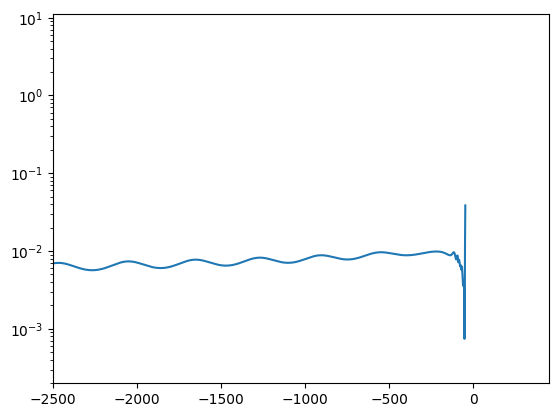

In [76]:
plt.yscale('log')
#plt.ylim(ymax=1e-1)
plt.ylim(ymin=2e-4)
plt.xlim(xmin=-2500)
plt.xlim(xmax=450)
plt.plot(t_intrp3/(M0*MTSUN_SI),abs(hp_intrp3+1j*hc_intrp3)/(G_SI*M_SI/D_SI/C_SI/C_SI )) 
#print(sph33)

100%|██████████████████████████████████| 181356/181356 [03:17<00:00, 918.06it/s]


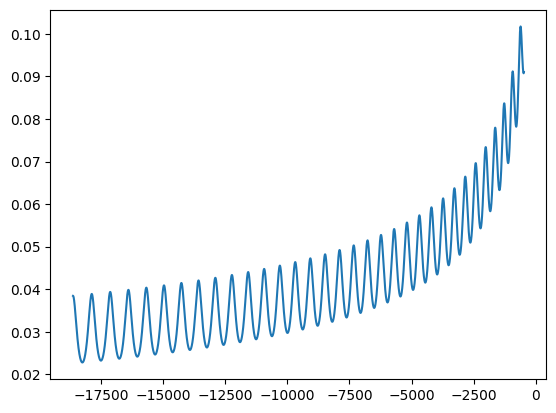

In [77]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=20
inc=10*np.pi/180
d0=1
delta_t=1./4096
x0=xlow=0.045
eta=neu=nu=q/(1+q)**2
Delta=math.sqrt(1-(4*neu))


kwargs = {
    "approximant": "EccentricTD",
    "q": q,
    "ecc": e0,
    "chi1": [0.0,0.0,0.0],
    "chi2": [0.0,0.0,0.0],
    "mean_ano": l0,
    "Momega0": 0.045**(3/2),
    "physicalUnits":True,
    "M": M0,
    "D":d0,
    "include_zero_ecc":True,
    }


method = "ResidualAmplitude"
origin = "LAL"
dataDict2 = load_waveform(origin, **kwargs)
hp33 = np.real(dataDict2["hlm"][(2,2)])
hc33 = np.imag(dataDict2["hlm"][(2,2)])

phs = np.unwrap(np.angle(hp33-1j*hc33)*3)/2
phs_intrp = interp1d(dataDict2["t"]/(M0*MTSUN_SI),phs,kind='cubic',fill_value = 'extrapolate')

return_dict = measure_eccentricity(fref_in=30,method=method,dataDict=dataDict2)

gwecc_object = return_dict["gwecc_object"]
Time_data = gwecc_object.get_omega22_average()[0]  #extract the time values
Omega_avg = gwecc_object.get_omega22_average()[1]

del_t=np.abs(np.mean((np.diff(Time_data))))
phs=phs_intrp(Time_data/(M0*MTSUN_SI))
omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

plt.plot(Time_data/(M0*MTSUN_SI),omega3)
return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
Fvec = Omega_avg/(2*PI) #Average frequency array

Fvec=Fvec*(M0*MTSUN_SI)


Eccentricity_new = return_dict1["eccentricity"]
Mean_anomaly = return_dict1["mean_anomaly"]


xiVec=(np.pi*M*Fvec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xVec = xVec


lp=3
mp=3
    
j=0
h33=[]
h3_3=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=Mean_anomaly[j]
    e=Eccentricity_new[j]
    psi= phs[j] #phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_33(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h33.append(abs(hlm)) #chnge
    h3_3.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph33, sph3_3 = sph_harmonics(inc,lp)
    
h = np.multiply(h33,1) #+np.multiply(h2_2,sph2_2) chnge
hp=(np.real(h)) 
hc=(np.imag(h)) 

mode3polfac=(21/(2*np.pi))**(1/2)
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = Time_data
hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp_new3 = np.arange(time[0], time[-1], delta_t)
hp_intrp_new3 = hp_intrp_new(t_intrp_new3)
hc_intrp_new3 = hc_intrp_new(t_intrp_new3)



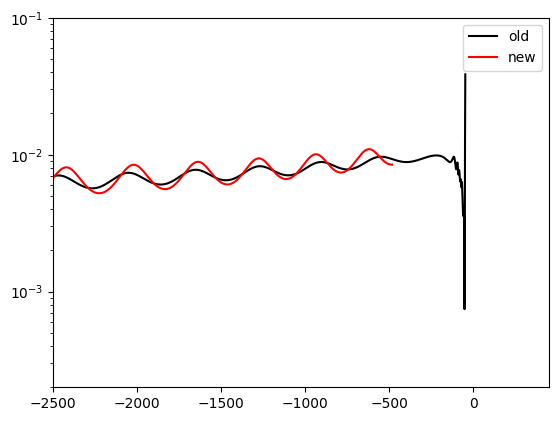

In [78]:
plt.yscale('log')
plt.ylim(ymax=1e-1)
plt.ylim(ymin=2e-4)
plt.xlim(xmin=-2500)
plt.xlim(xmax=450)
plt.plot(t_intrp3/(M0*MTSUN_SI),abs(hp_intrp3+1j*hc_intrp3)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-',label='old')
plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')
plt.legend()

# $44$

In [79]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=20
inc=10*np.pi/180
d0=1
delta_t=1./4096

eta=neu=nu=q/(1+q)**2
G=c=M=d=1
M2=M/(1+q)
M1=M2*q
Delta=math.sqrt(1-(4*neu))
eta=nu=neu
gamma=EulerGamma=0.577215664901
mode4polfac=(3/64)*(7/(1*np.pi))**(1/2)  
    
conv=M*MTSUN_SI
M_SI=M0 * MSUN_SI
D_SI=(10**(6)) * PC_SI * d
    
xlow = ((M0*MTSUN_SI*math.pi*flow)**(2/3))
f_low = (xlow**(3/2)/(M*MTSUN_SI*math.pi))
    
%run GW_functions.ipynb
    
x=xlow
v=math.sqrt(x)
    
xie=v**3
    
#if delta_t>=1/2**14:
    #del_t = 1/2**14
#elif delta_t<1/2**14 and delta_t>=1/2**16:
    #del_t = 1/2**16
#elif delta_t<1/2**16 and delta_t>=1/2**18:
    #del_t = 1/2**18
#else:
    #del_t = 1/2**20
        
phase_EccTD, tVec_PN = PNparams(M,q,d,f_low,e0,del_t)
    
tC_NR = 0
    
x0=xlow
xi0=x0**(3/2)
v0=xi0**(1/3)
   
theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta, theta0, e0, M, eta)

#print(fVec)
plotIdx2=np.nonzero(fVec>=0)
fVec=fVec[plotIdx2]
xiVec=(np.pi*M*fVec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xband=np.where(xVec<=1/6)
xVec = xVec[xband]
maxPNidx = len(xVec)
tVec_PN=tVec_PN[:maxPNidx]
    
    
lp=4
mp=4
    
j=0
h44=[]
h4_4=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=mean_anomaly(xie, xi0, l0, eta, e0)
    #print(l)
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_44(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h44.append(abs(hlm))
    h4_4.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph44, sph4_4 = sph_harmonics(inc,lp)
    
h = np.multiply(h44,1)#+np.multiply(h4_4,sph4_4)
hp=(np.real(h)) 
hc=(np.imag(h)) 
time = tVec_PN - tVec_PN[-1]

mode4polfac=(3/64)*(7/(1*np.pi))**(1/2) 
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = tVec_PN * conv_t
    
hp_intrp = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp4 = np.arange(time[0], time[-1], delta_t)
hp_intrp4 = hp_intrp(t_intrp4)
hc_intrp4 = hc_intrp(t_intrp4)

100%|█████████████████████████████████████| 6980/6980 [00:05<00:00, 1164.43it/s]


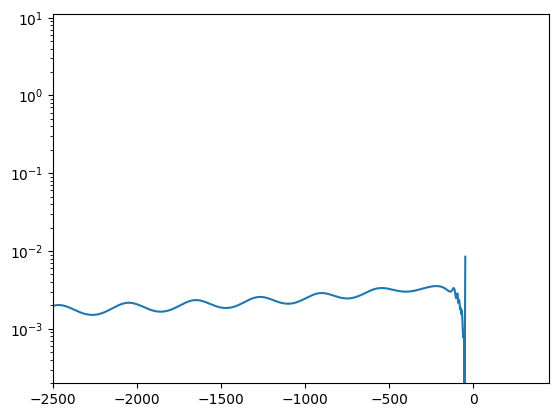

In [80]:
plt.yscale('log')
#plt.ylim(ymax=1e-1)
plt.ylim(ymin=2e-4)
plt.xlim(xmin=-2500)
plt.xlim(xmax=450)
plt.plot(t_intrp4/(M0*MTSUN_SI),abs(hp_intrp4+1j*hc_intrp4)/(G_SI*M_SI/D_SI/C_SI/C_SI))
#print(sph33)

100%|█████████████████████████████████| 181356/181356 [01:49<00:00, 1659.56it/s]


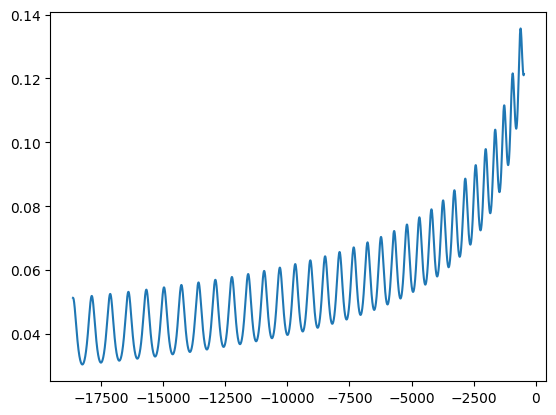

In [81]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=20
inc=10*np.pi/180
d0=1
delta_t=1./4096
x0=xlow=0.045
eta=neu=nu=q/(1+q)**2
Delta=math.sqrt(1-(4*neu))


kwargs = {
    "approximant": "EccentricTD",
    "q": q,
    "ecc": e0,
    "chi1": [0.0,0.0,0.0],
    "chi2": [0.0,0.0,0.0],
    "mean_ano": l0,
    "Momega0": 0.045**(3/2),
    "physicalUnits":True,
    "M": M0,
    "D":d0,
    "include_zero_ecc":True,
    }


method = "ResidualAmplitude"
origin = "LAL"
dataDict2 = load_waveform(origin, **kwargs)
hp44 = np.real(dataDict2["hlm"][(2,2)])
hc44 = np.imag(dataDict2["hlm"][(2,2)])

phs = np.unwrap(np.angle(hp44-1j*hc44)*4)/2
phs_intrp = interp1d(dataDict2["t"]/(M0*MTSUN_SI),phs,kind='cubic',fill_value = 'extrapolate')

return_dict = measure_eccentricity(fref_in=30,method=method,dataDict=dataDict2)

gwecc_object = return_dict["gwecc_object"]
Time_data = gwecc_object.get_omega22_average()[0]  #extract the time values
Omega_avg = gwecc_object.get_omega22_average()[1]

del_t=np.abs(np.mean((np.diff(Time_data))))
phs=phs_intrp(Time_data/(M0*MTSUN_SI))
omega4 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

plt.plot(Time_data/(M0*MTSUN_SI),omega4)
return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
Fvec = Omega_avg/(2*PI) #Average frequency array

Fvec=Fvec*(M0*MTSUN_SI)


Eccentricity_new = return_dict1["eccentricity"]
Mean_anomaly = return_dict1["mean_anomaly"]


xiVec=(np.pi*M*Fvec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xVec = xVec #[:10000]

lp=4
mp=4
    
j=0
h44=[]
h4_4=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=Mean_anomaly[j]
    e=Eccentricity_new[j]
    psi= phs[j] #phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_44(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h44.append(abs(hlm))
    h4_4.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph44, sph4_4 = sph_harmonics(inc,lp)
    
h = np.multiply(h44,1) #+np.multiply(h2_2,sph2_2)
hp=(np.real(h)) 
hc=(np.imag(h)) 

mode4polfac=(3/64)*(7/(1*np.pi))**(1/2) 
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = Time_data
hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp_new4 = np.arange(time[0], time[-1], delta_t)
hp_intrp_new4 = hp_intrp_new(t_intrp_new4)
hc_intrp_new4 = hc_intrp_new(t_intrp_new4)



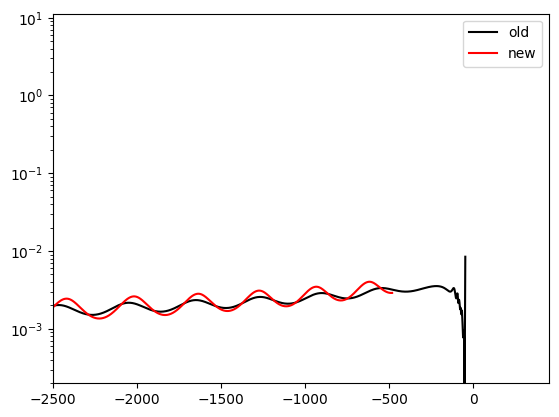

In [82]:
plt.yscale('log')
plt.yscale('log')
#plt.ylim(ymax=1e-1)
plt.ylim(ymin=2e-4)
plt.xlim(xmin=-2500)
plt.xlim(xmax=450)
plt.plot(t_intrp4/(M0*MTSUN_SI),abs(hp_intrp4+1j*hc_intrp4)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'k-',label='old')
plt.plot(t_intrp_new4/(M0*MTSUN_SI),abs(hp_intrp_new4+1j*hc_intrp_new4)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'r-',label='new')
plt.legend()

# $55$

In [83]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=20
inc=10*np.pi/180
d0=1
delta_t=1./4096

eta=neu=nu=q/(1+q)**2
G=c=M=d=1
M2=M/(1+q)
M1=M2*q
Delta=math.sqrt(1-(4*neu))
eta=nu=neu
gamma=EulerGamma=0.577215664901
mode5polfac=(330/(1*np.pi))**(1/2)    
    
conv=M*MTSUN_SI
M_SI=M0 * MSUN_SI
D_SI=(10**(6)) * PC_SI * d
    
xlow = ((M0*MTSUN_SI*math.pi*flow)**(2/3))
f_low = (xlow**(3/2)/(M*MTSUN_SI*math.pi))
    
%run GW_functions.ipynb
    
x=xlow
v=math.sqrt(x)
    
xie=v**3
    
#if delta_t>=1/2**14:
    #del_t = 1/2**14
#elif delta_t<1/2**14 and delta_t>=1/2**16:
    #del_t = 1/2**16
#elif delta_t<1/2**16 and delta_t>=1/2**18:
    #del_t = 1/2**18
#else:
    #del_t = 1/2**20
        
phase_EccTD, tVec_PN = PNparams(M,q,d,f_low,e0,del_t)
    
tC_NR = 0
    
x0=xlow
xi0=x0**(3/2)
v0=xi0**(1/3)
   
theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta, theta0, e0, M, eta)

#print(fVec)
plotIdx2=np.nonzero(fVec>=0)
fVec=fVec[plotIdx2]
xiVec=(np.pi*M*fVec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xband=np.where(xVec<=1/6)
xVec = xVec[xband]
maxPNidx = len(xVec)
tVec_PN=tVec_PN[:maxPNidx]
    
    
lp=5
mp=5
    
j=0
h55=[]
h5_5=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=mean_anomaly(xie, xi0, l0, eta, e0)
    #print(l)
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_55(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h55.append(abs(hlm))
    h5_5.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph55, sph5_5 = sph_harmonics(inc,lp)
    
h = np.multiply(h55,1)#+np.multiply(h4_4,sph4_4)
hp=(np.real(h)) 
hc=(np.imag(h)) 
time = tVec_PN - tVec_PN[-1]

mode5polfac=(330/(1*np.pi))**(1/2)
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = tVec_PN * conv_t
    
hp_intrp = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp5 = np.arange(time[0], time[-1], delta_t)
hp_intrp5 = hp_intrp(t_intrp5)
hc_intrp5 = hc_intrp(t_intrp5)

100%|█████████████████████████████████████| 6980/6980 [00:02<00:00, 2682.98it/s]


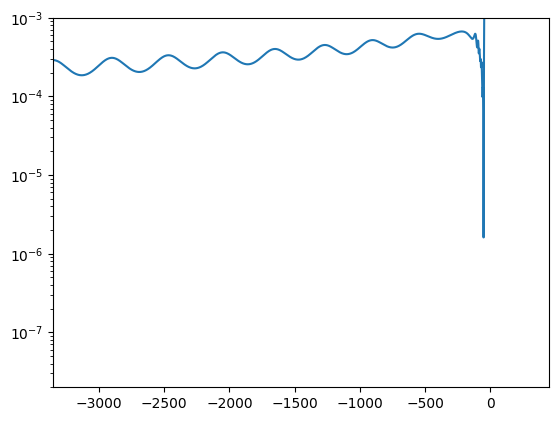

In [84]:
plt.yscale('log')
plt.ylim(ymax=1e-3)
plt.ylim(ymin=2e-8)
plt.xlim(xmin=-3350)
plt.xlim(xmax=450)
plt.plot(t_intrp5/(M0*MTSUN_SI),abs(hp_intrp5+1j*hc_intrp5)/(G_SI*M_SI/D_SI/C_SI/C_SI ))
#print(sph33)

100%|█████████████████████████████████| 181356/181356 [01:06<00:00, 2741.74it/s]


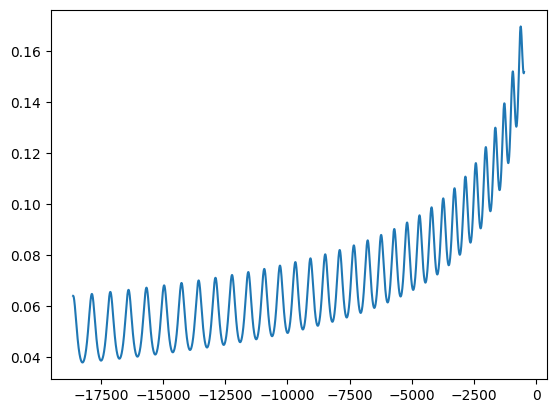

In [85]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=20
inc=10*np.pi/180
d0=1
delta_t=1./4096
x0=xlow=0.045
eta=neu=nu=q/(1+q)**2
Delta=math.sqrt(1-(4*neu))


kwargs = {
    "approximant": "EccentricTD",
    "q": q,
    "ecc": e0,
    "chi1": [0.0,0.0,0.0],
    "chi2": [0.0,0.0,0.0],
    "mean_ano": l0,
    "Momega0": 0.045**(3/2),
    "physicalUnits":True,
    "M": M0,
    "D":d0,
    "include_zero_ecc":True,
    }


method = "ResidualAmplitude"
origin = "LAL"
dataDict2 = load_waveform(origin, **kwargs)
hp55 = np.real(dataDict2["hlm"][(2,2)])
hc55 = np.imag(dataDict2["hlm"][(2,2)])

phs = np.unwrap(np.angle(hp55-1j*hc55)*5)/2
phs_intrp = interp1d(dataDict2["t"]/(M0*MTSUN_SI),phs,kind='cubic',fill_value = 'extrapolate')


return_dict = measure_eccentricity(fref_in=30,method=method,dataDict=dataDict2)

gwecc_object = return_dict["gwecc_object"]
Time_data = gwecc_object.get_omega22_average()[0]  #extract the time values
Omega_avg = gwecc_object.get_omega22_average()[1]

del_t=np.abs(np.mean((np.diff(Time_data))))
phs=phs_intrp(Time_data/(M0*MTSUN_SI))
omega5 = (M0*MTSUN_SI/del_t)*np.gradient(phs)
plt.plot(Time_data/(M0*MTSUN_SI),omega5)
return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
Fvec = Omega_avg/(2*PI) #Average frequency array

Fvec=Fvec*(M0*MTSUN_SI)


Eccentricity_new = return_dict1["eccentricity"]
Mean_anomaly = return_dict1["mean_anomaly"]


xiVec=(np.pi*M*Fvec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xVec = xVec #[:10000]


lp=5
mp=5
    
j=0
h55=[]
h5_5=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=Mean_anomaly[j]
    e=Eccentricity_new[j]
    psi= phs[j] #phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_55(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h55.append(abs(hlm))
    h5_5.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph55, sph5_5 = sph_harmonics(inc,lp)
    
h = np.multiply(h55,1) #+np.multiply(h2_2,sph2_2)
hp=(np.real(h)) 
hc=(np.imag(h)) 

mode5polfac=(330/(1*np.pi))**(1/2)
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = Time_data
hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp_new5 = np.arange(time[0], time[-1], delta_t)
hp_intrp_new5 = hp_intrp_new(t_intrp_new5)
hc_intrp_new5 = hc_intrp_new(t_intrp_new5)



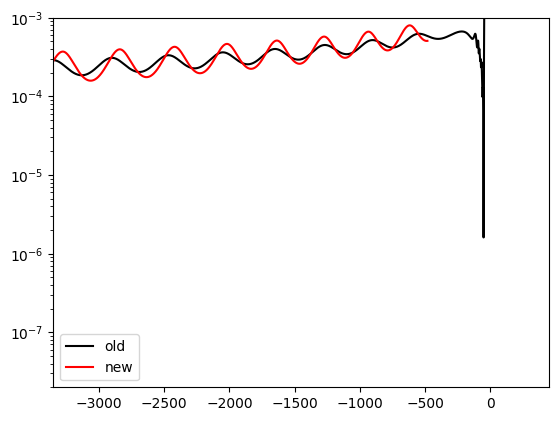

In [86]:
plt.yscale('log')
plt.ylim(ymax=1e-3)
plt.ylim(ymin=2e-8)
plt.xlim(xmin=-3350)
plt.xlim(xmax=450)
plt.plot(t_intrp5/(M0*MTSUN_SI),abs(hp_intrp5+1j*hc_intrp5)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-',label='old')
plt.plot(t_intrp_new5/(M0*MTSUN_SI),abs(hp_intrp_new5+1j*hc_intrp_new5)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'r-',label='new')
plt.legend()

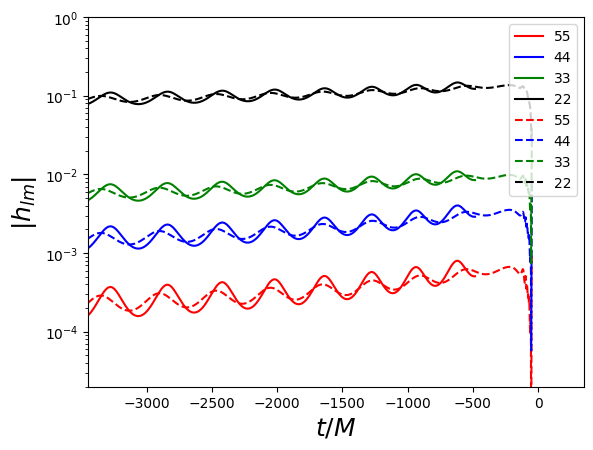

In [87]:
plt.ylim(ymax=1e0)
#plt.ylim(ymin=3e-6)
plt.ylim(ymin=2e-5)
plt.xlim(xmin=-3450)
plt.xlim(xmax=350)
plt.ylabel(r'$|h_{lm}|$',size=18)
plt.xlabel(r'$t/M$',size=18)
plt.yscale('log')
plt.plot(t_intrp_new5/(M0*MTSUN_SI),abs(hp_intrp_new5+1j*hc_intrp_new5)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'r',label='55')
plt.plot(t_intrp_new4/(M0*MTSUN_SI),abs(hp_intrp_new4+1j*hc_intrp_new4)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'b',label='44')
plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'g',label='33')
plt.plot(t_intrp_new2/(M0*MTSUN_SI),abs(hp_intrp_new2+1j*hc_intrp_new2)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'k',label='22')


plt.plot(t_intrp5/(M0*MTSUN_SI),abs(hp_intrp5+1j*hc_intrp5)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'r',linestyle='--',label='55')
plt.plot(t_intrp4/(M0*MTSUN_SI),abs(hp_intrp4+1j*hc_intrp4)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'b',linestyle='--',label='44')
plt.plot(t_intrp3/(M0*MTSUN_SI),abs(hp_intrp3+1j*hc_intrp3)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'g',linestyle='--',label='33')
plt.plot(t_intrp2/(M0*MTSUN_SI),abs(hp_intrp2+1j*hc_intrp2)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'k',linestyle='--',label='22')

plt.legend()

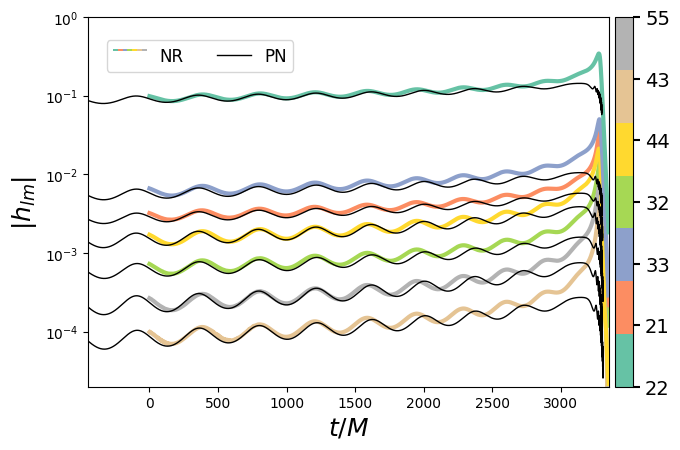

17721 17721


In [112]:
plt.figure(figsize=(8,4.8))
N = 7
cmap = plt.get_cmap('Set2', N)
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)

cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
#cbar.set_label(label='mode',size=20)
cbar.set_ticklabels(["22","21","33","32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)




import numpy as np
a55=np.loadtxt('PN55.txt')[:,0]
b55=np.loadtxt('PN55.txt')[:,1]
c55=np.loadtxt('NR55.txt')[:,0]
d55=np.loadtxt('NR55.txt')[:,1]
a43=np.loadtxt('PN43.txt')[:,0]
b43=np.loadtxt('PN43.txt')[:,1]
c43=np.loadtxt('NR43.txt')[:,0]
d43=np.loadtxt('NR43.txt')[:,1]
a44=np.loadtxt('PN44.txt')[:,0]
b44=np.loadtxt('PN44.txt')[:,1]
c44=np.loadtxt('NR44.txt')[:,0]
d44=np.loadtxt('NR44.txt')[:,1]
a32=np.loadtxt('PN32.txt')[:,0]
b32=np.loadtxt('PN32.txt')[:,1]
c32=np.loadtxt('NR32.txt')[:,0]
d32=np.loadtxt('NR32.txt')[:,1]
a33=np.loadtxt('PN33.txt')[:,0]
b33=np.loadtxt('PN33.txt')[:,1]
c33=np.loadtxt('NR33.txt')[:,0]
d33=np.loadtxt('NR33.txt')[:,1]
a21=np.loadtxt('PN21.txt')[:,0]
b21=np.loadtxt('PN21.txt')[:,1]
c21=np.loadtxt('NR21.txt')[:,0]
d21=np.loadtxt('NR21.txt')[:,1]
a22=np.loadtxt('PN22.txt')[:,0]
b22=np.loadtxt('PN22.txt')[:,1]
c22=np.loadtxt('NR22.txt')[:,0]
d22=np.loadtxt('NR22.txt')[:,1]
import matplotlib.pyplot as plt

plt.plot(c55,d55,linewidth=3.0,zorder=4,c=cmap(6))

plt.plot(c43,d43,c=cmap(5),zorder=1,linewidth=3.0)

plt.plot(c44,d44,c=cmap(4),linewidth=3.0,zorder=4)

plt.plot(c32,d32,c=cmap(3),linewidth=3.0,zorder=3)

plt.plot(c33,d33,c=cmap(2),linewidth=3.0,zorder=4)

plt.plot(c21,d21,c=cmap(1),linewidth=3.0,zorder=3)

plt.plot(c22,d22,c=cmap(0),linewidth=3.0,zorder=4)
plt.plot(a55,b55,'k-',linewidth=1,zorder=5,label='PN')
plt.plot(a43,b43,'k-',linewidth=1,zorder=5)
plt.plot(a44,b44,'k-',linewidth=1,zorder=5)
plt.plot(a32,b32,'k-',linewidth=1,zorder=5)
plt.plot(a33,b33,'k-',linewidth=1,zorder=5)
plt.plot(a21,b21,'k-',linewidth=1,zorder=5)
plt.plot(a22,b22,'k-',linewidth=1,zorder=5)


plt.ylim(ymax=1e0)
#plt.ylim(ymin=3e-6)
plt.ylim(ymin=2e-5)
plt.xlim(xmin=-450)
plt.xlim(xmax=3350)
plt.ylabel(r'$|h_{lm}|$',size=18)
plt.xlabel(r'$t/M$',size=18)
plt.yscale('log')


plt.minorticks_off()
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase
class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent+7], 
                          width / self.num_stripes, 
                          height/4.5, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size
cmaps = [plt.get_cmap('Set2', 7)]#[plt.cm.Set2]  # set of colormaps 
                                        # (as many as there are groups of lines)

for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)

    # plot lines with color depending on param using different colormaps:
    plt.plot(x_line1, y_line1, c=cmaps[0](param / param_max))
    plt.plot(x_line2, y_line2)


lgd = Line2D([0], [0], color='black', lw=1)   
    
cmap_labels = ["NR","PN"]
cmap_handles = [Rectangle((0, 0), 1, 1)]
cmap_handles.append(lgd)
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=7) for cm in cmaps]))
plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,bbox_to_anchor=(0.02,0.96),prop={'size': 12}, ncol = 2, loc=2)




plt.savefig('Ebersoldplot.png',dpi=600)
plt.show()
print(len(c55),len(d55))

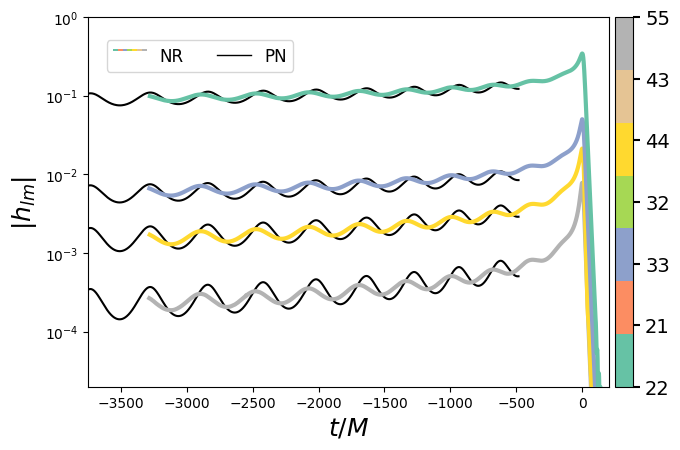

In [163]:
plt.figure(figsize=(8,4.8))
N = 7
cmap = plt.get_cmap('Set2', N)
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)

cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
#cbar.set_label(label='mode',size=20)
cbar.set_ticklabels(["22","21","33","32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)




import numpy as np
a55=np.loadtxt('PN55.txt')[:,0]
b55=np.loadtxt('PN55.txt')[:,1]
c55=np.loadtxt('NR55.txt')[:,0]
d55=np.loadtxt('NR55.txt')[:,1]
a43=np.loadtxt('PN43.txt')[:,0]
b43=np.loadtxt('PN43.txt')[:,1]
c43=np.loadtxt('NR43.txt')[:,0]
d43=np.loadtxt('NR43.txt')[:,1]
a44=np.loadtxt('PN44.txt')[:,0]
b44=np.loadtxt('PN44.txt')[:,1]
c44=np.loadtxt('NR44.txt')[:,0]
d44=np.loadtxt('NR44.txt')[:,1]
a32=np.loadtxt('PN32.txt')[:,0]
b32=np.loadtxt('PN32.txt')[:,1]
c32=np.loadtxt('NR32.txt')[:,0]
d32=np.loadtxt('NR32.txt')[:,1]
a33=np.loadtxt('PN33.txt')[:,0]
b33=np.loadtxt('PN33.txt')[:,1]
c33=np.loadtxt('NR33.txt')[:,0]
d33=np.loadtxt('NR33.txt')[:,1]
a21=np.loadtxt('PN21.txt')[:,0]
b21=np.loadtxt('PN21.txt')[:,1]
c21=np.loadtxt('NR21.txt')[:,0]
d21=np.loadtxt('NR21.txt')[:,1]
a22=np.loadtxt('PN22.txt')[:,0]
b22=np.loadtxt('PN22.txt')[:,1]
c22=np.loadtxt('NR22.txt')[:,0]
d22=np.loadtxt('NR22.txt')[:,1]
import matplotlib.pyplot as plt

ind=np.where(d55==max(d55))[0][0]
plt.plot(c55-c55[np.where(d55==max(d55))[0][0]],d55,linewidth=3.0,zorder=4,c=cmap(6))

plt.plot(c44-c44[np.where(d44==max(d44))[0][0]],d44,c=cmap(4),linewidth=3.0,zorder=4)


plt.plot(c33-c33[np.where(d33==max(d33))[0][0]],d33,c=cmap(2),linewidth=3.0,zorder=4)

plt.plot(c22-c22[np.where(d22==max(d22))[0][0]],d22,c=cmap(0),linewidth=3.0,zorder=4)

plt.plot(t_intrp_new5/(M0*MTSUN_SI),abs(hp_intrp_new5+1j*hc_intrp_new5)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'k',label='55')
plt.plot(t_intrp_new4/(M0*MTSUN_SI),abs(hp_intrp_new4+1j*hc_intrp_new4)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'k',label='44')
plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'k',label='33')
plt.plot(t_intrp_new2/(M0*MTSUN_SI),abs(hp_intrp_new2+1j*hc_intrp_new2)/(G_SI*M_SI/D_SI/C_SI/C_SI ),'k',label='22')





plt.ylim(ymax=1e0)
#plt.ylim(ymin=3e-6)
plt.ylim(ymin=2e-5)
plt.xlim(xmin=-3750)
plt.xlim(xmax=200)
plt.ylabel(r'$|h_{lm}|$',size=18)
plt.xlabel(r'$t/M$',size=18)
plt.yscale('log')


plt.minorticks_off()
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase
class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent+7], 
                          width / self.num_stripes, 
                          height/4.5, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size
cmaps = [plt.get_cmap('Set2', 7)]#[plt.cm.Set2]  # set of colormaps 
                                        # (as many as there are groups of lines)

for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)

    # plot lines with color depending on param using different colormaps:
    plt.plot(x_line1, y_line1, c=cmaps[0](param / param_max))
    plt.plot(x_line2, y_line2)


lgd = Line2D([0], [0], color='black', lw=1)   
    
cmap_labels = ["NR","PN"]
cmap_handles = [Rectangle((0, 0), 1, 1)]
cmap_handles.append(lgd)
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=7) for cm in cmaps]))
plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,bbox_to_anchor=(0.02,0.96),prop={'size': 12}, ncol = 2, loc=2)




#plt.savefig('Ebersoldplot.png',dpi=600)
plt.show()

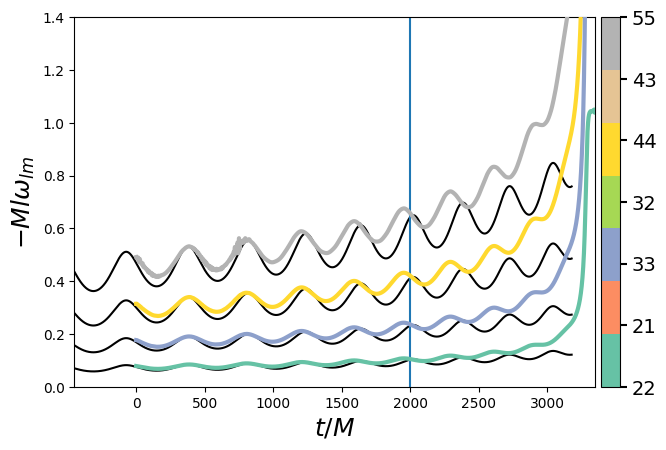

In [161]:
plt.figure(figsize=(8,4.8))
N = 7
cmap = plt.get_cmap('Set2', N)
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)

cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
#cbar.set_label(label='mode',size=20)
cbar.set_ticklabels(["22","21","33","32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)




import numpy as np
a55=np.loadtxt('pn55.txt')[:,0]
b55=np.loadtxt('pn55.txt')[:,1]
c55=np.loadtxt('nr55.txt')[:,0]
d55=np.loadtxt('nr55.txt')[:,1]
a43=np.loadtxt('pn43.txt')[:,0]
b43=np.loadtxt('pn43.txt')[:,1]
c43=np.loadtxt('nr43.txt')[:,0]
d43=np.loadtxt('nr43.txt')[:,1]
a44=np.loadtxt('pn44.txt')[:,0]
b44=np.loadtxt('pn44.txt')[:,1]
c44=np.loadtxt('nr44.txt')[:,0]
d44=np.loadtxt('nr44.txt')[:,1]
a32=np.loadtxt('pn32.txt')[:,0]
b32=np.loadtxt('pn32.txt')[:,1]
c32=np.loadtxt('nr32.txt')[:,0]
d32=np.loadtxt('nr32.txt')[:,1]
a33=np.loadtxt('pn33.txt')[:,0]
b33=np.loadtxt('pn33.txt')[:,1]
c33=np.loadtxt('nr33.txt')[:,0]
d33=np.loadtxt('nr33.txt')[:,1]
a21=np.loadtxt('pn21.txt')[:,0]
b21=np.loadtxt('pn21.txt')[:,1]
c21=np.loadtxt('nr21.txt')[:,0]
d21=np.loadtxt('nr21.txt')[:,1]
a22=np.loadtxt('pn22.txt')[:,0]
b22=np.loadtxt('pn22.txt')[:,1]
c22=np.loadtxt('nr22.txt')[:,0]
d22=np.loadtxt('nr22.txt')[:,1]
import matplotlib.pyplot as plt



plt.plot(Time_data/(M0*MTSUN_SI)+3660,2*omega2,'k')
plt.plot(Time_data/(M0*MTSUN_SI)+3660,3*omega3,'k')
plt.plot(Time_data/(M0*MTSUN_SI)+3660,4*omega4,'k')
plt.plot(Time_data/(M0*MTSUN_SI)+3660,5*omega5,'k')

plt.plot(c55,d55,linewidth=3.0,zorder=4,c=cmap(6))
#print(len(c43))


plt.plot(c44,d44,c=cmap(4),linewidth=3.0,zorder=4)



plt.plot(c33,d33,c=cmap(2),linewidth=3.0,zorder=4)



plt.plot(c22,d22,c=cmap(0),linewidth=3.0,zorder=4)


plt.axvline(x=2000)

plt.ylim(ymax=1.4)
#plt.ylim(ymin=3e-6)
plt.ylim(ymin=0.0)
plt.xlim(xmin=-450)
plt.xlim(xmax=3350)
plt.ylabel(r'$-Ml\omega_{lm}$',size=18)
plt.xlabel(r'$t/M$',size=18)
#plt.yscale('log')

plt.show()